In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import numpy.random as random
import scipy.io, scipy.interpolate
import matplotlib.pyplot as plt
import synthetic_data

## Notation

* $\theta$: the parameters we're trying to infer: here, $a$, $s_a$, and $s_u$.
* $\phi$: the fictitious momentum
* $P(\theta)$: the probability density function of the parameters
* $\tau$: fictitious time

## Hamiltonian Monte Carlo
The algorithm:

0. Pick a starting parameter $\theta_0$ however you like.
1. Pick a starting momentum $\phi_0$ sampled from a normal distribution.
2. Solve Hamilton's equation's of motion up to some time $\tau$.
3. Accept/reject the new state $\theta_\tau, \phi_\tau$ according to the usual MCMC criterion:
$$\min\{1, \exp\left[B(H(\theta_0, \phi_0) - H(\theta_\tau, \phi_\tau))\right]\}$$
4. Throw out the momentum and go back to (1).

## Some fake data

Load some synthetic data produced in synthetic_data.py

In [2]:
x, dx, target_layers, target_ages, a, u, a_scale_data, u_scale_data, uncertainty, z = synthetic_data.load()
timestep_target = 20  # This is our target year spacing
target_ages = np.array(target_ages)
uncertainty = np.ones_like(uncertainty)

times = np.flip(-np.hstack([np.linspace(0, target_ages[0], int(np.round(target_ages[0] / timestep_target)) + 1)[:-1]] +
                  [np.linspace(target_ages[i], target_ages[i + 1], int(np.round((target_ages[i + 1] - target_ages[i]) / timestep_target)) + 1)[:-1] for i in range(len(target_ages) - 1)] +
                  [np.array(target_ages[-1])]))
compare_indices = np.flip(len(times) - 1 - np.array([i for i in range(len(times)) if np.any(times[i] == -target_ages)]))
timesteps = np.diff(times)
num_steps = len(timesteps)

Given the present-day accumulation rate $a(x)$, ice velocity $u(x)$, and the scaling factors $s_a(t)$, $s_u(t)$, David's model for the layer depth $z$ is the solution of the advection equation

$$\frac{\partial z}{\partial t} - s_u(t)u(x)\frac{\partial z}{\partial x} = s_a(t) \cdot DJ(a, z),$$

$$\frac{\partial z}{\partial x}\Big|_{x = L} = 0.$$

up to the final time $t_f$, where $DJ$ is the Dansgaard-Johnsen model for the vertical velocity.
David used an arbitrary Lagrangian-Eulerian scheme to solve these equations.

**One of the hard parts of using HMC is calculating derivatives of the objective w.r.t. the parameters.**
To be able to calculate derivatives, I had to use a more old-fashioned backward Euler integration scheme to solve the model physics.
I calculated the derivatives using the adjoint method.
The derivatives were very inaccurate without a small timestep.

/Users/dlilien/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


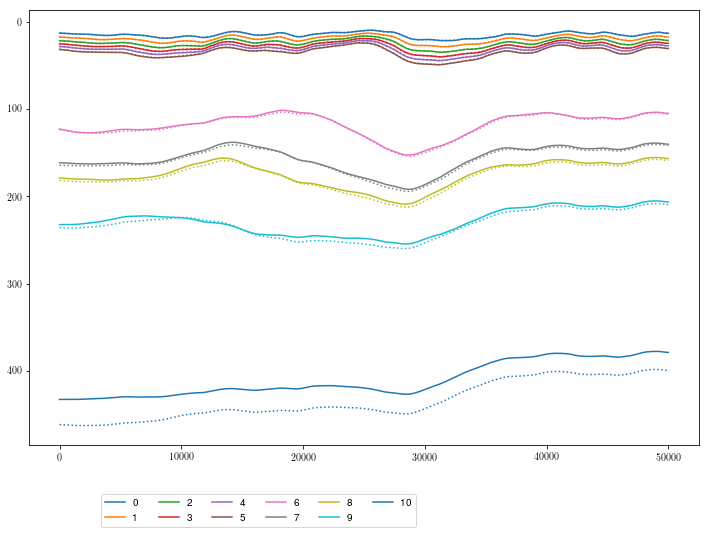

In [3]:
import model

accumulation_scale = np.ones(num_steps)
velocity_scale = np.ones(num_steps)

z = model.layer_depth(x, accumulation_scale, velocity_scale, a, u, timesteps)

# We are going to do this to see how we are doing at every layer
# It should give us a good idea of whether dJ_da should be positive
plt.figure(figsize=(12, 8))
for i, index in enumerate(compare_indices):
    ln = plt.plot(x, z[index], linestyle='dotted')
    plt.plot(x, target_layers[i, :].flatten(), color=ln[0].get_color(), linestyle='solid', label=str(i))
plt.legend(loc='upper left', bbox_to_anchor=(0.1, -0.1), ncol=6)
plt.gca().invert_yaxis()

The figure below shows the sensitivity of the mean-square error to changes in the accumulation scale over time.

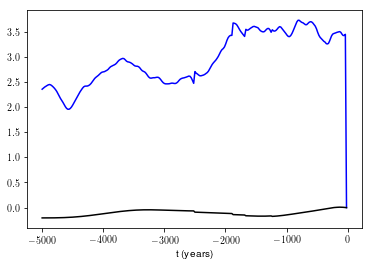

In [4]:
dJ_da = model.derivative_scales(x, accumulation_scale, velocity_scale,
                                a, u, z, target_layers,
                                compare_indices, timesteps,
                                uncertainty=uncertainty)

fig, ax = plt.subplots()
plt.plot(times[:-1], dJ_da[:len(times[:-1])], color='b')
plt.plot(times[:-1], dJ_da[len(times[:-1]):], color='k')


ax.set_xlabel('t (years)')
plt.show(fig)

## Skeleton of HMC

We now have everything in place to start sampling from the PDF for David's data and model!

In order to make the runs reproducible, we'll use a `RandomState` object from numpy for all our random number generation.
If some run is particularly interesting, we can serialize the random state object, save it to disk, and deserialize it later when we want to reproduce the run identically.
This involves some extra book-keeping but you should always do it.

In [5]:
random_state = random.RandomState()

Last week, we discussed using regularization in order to select for smooth values of the parameters; this is equivalent to a certain choice of prior in Bayesian inference.
We'll do the same thing this time.
**How you regularize the problem determines the choice of mass matrix**, i.e. how the different components of the momentum vector are coupled together.

Note how we divide by the square root of the number of time steps to get the right total variance.

In [6]:
r = 40
import scipy.sparse, scipy.sparse.linalg, numpy.linalg

Id_single = scipy.sparse.diags([np.ones(num_steps)], [0])
diag_single = np.ones(num_steps)
D_single = scipy.sparse.diags([diag_single, -diag_single], [0, 1], shape=(len(timesteps) - 1, len(timesteps))) / np.mean(timesteps)
L2 = r**2 * D_single.T * D_single * np.mean(timesteps)
M_single = Id_single + L2

M = scipy.sparse.csr_matrix(np.hstack((np.vstack((M_single.toarray(), np.zeros_like(M_single.toarray()))), np.vstack((np.zeros_like(M_single.toarray()), M_single.toarray())))))
assert np.all(M[:num_steps, :num_steps].toarray() == M_single.toarray())
assert np.all(M[num_steps:, num_steps:].toarray() == M_single.toarray())
# M = M_single

λs, vs = numpy.linalg.eigh(M.toarray())

def generate_momentum(random_state, σ):
    ζ = random_state.normal(size=num_steps * 2)
    return sum(((ζ[k] * np.sqrt(λs[k] / (num_steps * 2)) * σ) * vs[:, k] for k in range(2 * num_steps)))
    # ζ = random_state.normal(size=num_steps)
    # return sum(((ζ[k] * np.sqrt(λs[k] / num_steps) * σ) * vs[:, k] for k in range(num_steps)))

The following functions calculate each part of the Hamiltonian and its derivatives.
The final term in the potential -- `np.dot(θ, L * θ)` -- is what adds the penalty for oscillatory solutions.

In [7]:
def potential_energy(θ_a, θ_v):
    z_θ = model.layer_depth(x, θ_a, θ_v, a, u, timesteps)
    return np.nansum(model.msm(x, z_θ[compare_indices,:], target_layers, uncertainty=uncertainty) + 0.5 * np.dot(θ_a, L2 * θ_a) + 0.5 * np.dot(θ_v, L2 * θ_v))

def kinetic_energy(ϕ):
    return 0.5 * np.dot(ϕ.flatten(), scipy.sparse.linalg.spsolve(M, ϕ))

def hamiltonian(ϕ, θ_a, θ_v):
    return potential_energy(θ_a, θ_v) + kinetic_energy(ϕ)

def force(θ_a, θ_v):
    z_θ = model.layer_depth(x, θ_a, θ_v, a, u, timesteps)
    return -model.derivative_scales(x, θ_a, θ_v, a, u, z_θ, target_layers, compare_indices, timesteps, uncertainty=uncertainty) - np.hstack((L2 * θ_a, L2 * θ_v))
    # return -model.derivative_ascale(x, θ_a, θ_v, a, u, z_θ, target_layers, compare_indices, timesteps, uncertainty=uncertainty) - L2 * θ_a

def velocity(ϕ):
    return scipy.sparse.linalg.spsolve(M, ϕ)

In [8]:
def accept_or_reject(KE_0, PE_0, KE_1, PE_1, rescale=1.0):
    """Return true if you should accept, false if you should reject. Reject if we have NaNs in the new Hamiltonian calculation"""
    H_0 = KE_0 + PE_0
    H_1 = KE_1 + PE_1
    if np.isnan(H_1):
        return False
    else:
        return (np.random.rand(1) < min(1., np.exp((H_0 - H_1) / rescale)))[0]

This function implements the Verlet method for numerically integrating a Hamiltonian system.

In [9]:
def hamiltonian_update(δτ, θ_a, θ_v, ϕ):
    vel = velocity(ϕ)
    θ_a_τ  = θ_a + 0.5 * δτ * vel[:len(θ_a)]
    θ_v_τ = θ_v
    θ_v_τ  = θ_v + 0.5 * δτ * vel[len(θ_a):]

    ϕ_τ = ϕ + δτ * (force(θ_a_τ, θ_v_τ))
    
    vel = velocity(ϕ_τ)
    θ_a_τ += 0.5 * δτ * vel[:len(θ_a)]
    θ_v_τ += 0.5 * δτ * vel[len(θ_a):]
    
    return θ_a_τ, θ_v_τ, ϕ_τ

def integrate_phase_space(δτ, num_hamiltonian_steps, θ_a, θ_v, ϕ):
    print('Going along phase space')
    for k in range(num_hamiltonian_steps):
        print('..{:d}'.format(k), end='')
        θ_a, θ_v, ϕ = hamiltonian_update(δτ, θ_a, θ_v, ϕ)
    return θ_a, θ_v, ϕ

In [10]:
θ_a = accumulation_scale.copy()
θ_v = velocity_scale.copy()

ϕ = generate_momentum(random_state, 1)

Solve the system using a fictitious timestep of 1/32 for 2/3 of a fictitious time unit.
I had to hand-tune both of these parameters to get something sensible.

In [11]:
δτ = 0.02
# num_hamiltonian_steps = int(1.0 / 4.0 / δτ)
num_hamiltonian_steps = 10

for k in range(num_hamiltonian_steps):
    θ_a, θ_v, ϕ = hamiltonian_update(δτ, θ_a, θ_v, ϕ)
    print('{:d}: {:E} {:E}'.format(k, kinetic_energy(ϕ), potential_energy(θ_a, θ_v)))

0: 9.514880E-01 1.473839E+07
1: 2.231042E+00 1.380472E+07
2: 4.206563E+00 1.237954E+07
3: 6.657268E+00 1.064362E+07
4: 9.312436E+00 8.816907E+06
5: 1.188401E+01 7.130443E+06
6: 1.410133E+01 5.796688E+06
7: 1.574385E+01 4.981873E+06
8: 1.666771E+01 4.783958E+06
9: 1.682280E+01 5.219128E+06


Compute a few statistics of the resulting random state.

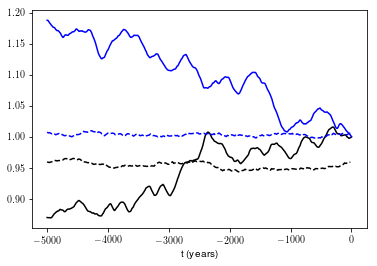

In [12]:
fig, ax = plt.subplots()
ax.plot(np.linspace(-5000, 0, len(u_scale_data)), a_scale_data, color='k')
ax.plot(times[:-1], θ_a, color='k', linestyle='dashed')
ax.plot(np.linspace(-5000, 0, len(u_scale_data)), u_scale_data, color='b')
ax.plot(times[:-1], θ_v, color='b', linestyle='dashed')

ax.set_xlabel('t (years)')
plt.show(fig)

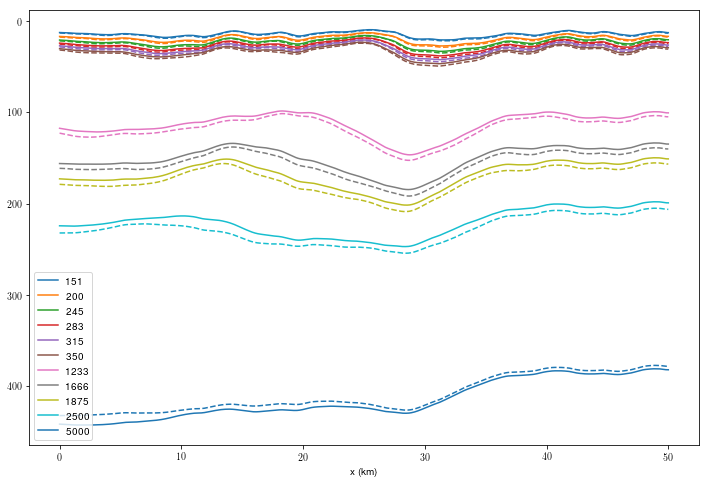

In [13]:
z_θ = model.layer_depth(x, θ_a, θ_v, a, u, timesteps)

fig, ax = plt.subplots(figsize=(12, 8))
for i, index in enumerate(compare_indices):
    ln = plt.plot(x/1000, z_θ[index], label=str(target_ages[i]))
    ax.plot(x/1000, target_layers[i, :], color=ln[0].get_color(), linestyle='dashed')
ax.legend(loc='best')
ax.set_xlabel("x (km)")
ax.invert_yaxis()
plt.show(fig)

## HMC sampling

Now let's generate a bunch of samples and see what the resulting ensemble looks like.

In [14]:
num_samples = 100

θs = np.zeros((num_samples, num_steps))
θs[0, :] = θ_a.copy()
θsv = np.zeros((num_samples, num_steps))
θsv[0, :] = θ_v.copy()
KEs = np.zeros((num_samples,))
PEs = np.zeros((num_samples,))
PEs[0] = potential_energy(θ_a, θ_v)
KEs[0] = kinetic_energy(ϕ)

sample = 1
num_accepted = 0
num_rejected = 0
while sample < num_samples:
    print(sample, ':   ', end='')
    ϕ_0 = generate_momentum(random_state, 1)
    ϕ = ϕ_0.copy()
    θ_a = θs[sample - 1, :].copy()
    θ_v = θsv[sample - 1, :].copy()
    θ_a, θ_v, ϕ = integrate_phase_space(δτ, num_hamiltonian_steps, θ_a, θ_v, ϕ)
    KEs[sample] = kinetic_energy(ϕ)
    PEs[sample] = potential_energy(θ_a, θ_v)
    print('')
    print('{:E} {:E}'.format(KEs[sample], PEs[sample]))
    print('')
    if accept_or_reject(KEs[sample - 1], PEs[sample - 1], KEs[sample], PEs[sample]):
        θs[sample, :] = θ_a.copy()
        θsv[sample, :] = θ_v.copy()
        sample += 1
        num_accepted += 1
    else:
        num_rejected += 1
        print('Redoing iteration: H_0={:E} while H_1={:E}'.format(KEs[sample - 1] + PEs[sample - 1], KEs[sample] + PEs[sample]))

1 :   Going along phase space
..0..1..2..3..4..5..6..7..8..9
3.223365E+00 2.109545E+06

2 :   Going along phase space
..0..1..2..3..4..5..6..7..8..9
1.720676E+00 1.286383E+06

3 :   Going along phase space
..0..1..2..3..4..5..6..7..8..9
8.813247E-01 8.630892E+05

4 :   Going along phase space
..0..1..2..3..4..5..6..7..8..9
6.747255E-01 6.591559E+05

5 :   Going along phase space
..0..1..2..3..4..5..6..7..8..9
6.596879E-01 5.165265E+05

6 :   Going along phase space
..0..1..2..3..4..5..6..7..8..9
5.945696E-01 4.308848E+05

7 :   Going along phase space
..0..1..2..3..4..5..6..7..8..9
4.935158E-01 3.858041E+05

8 :   Going along phase space
..0..1..2..3..4..5..6..7..8..9
5.149319E-01 3.771989E+05

9 :   Going along phase space
..0..1..2..3..4..5..6..7..8..9
5.254207E-01 3.602884E+05

10 :   Going along phase space
..0..1..2..3..4..5..6..7..8..9
5.262807E-01 3.368386E+05

11 :   Going along phase space
..0..1..2..3..4..5..6..7..8..9
4.724719E-01 3.203686E+05

12 :   Going along phase space

KeyboardInterrupt: 

In [ ]:
print('Rejected {:d} samples of {:d}'.format(num_rejected, num_accepted + num_rejected))
print('Acceptance percentage {:f}'.format(num_accepted / (num_accepted + num_rejected)))

Lighter colors are earlier runs, darker colors are later ones.
We can clearly see the guesses migrating through parameter space.

In [ ]:
min_PE = np.min(PEs)
pre_samples = np.min(np.where(PEs < 1.1 * min_PE))
print(pre_samples)

cm1 = plt.get_cmap('autumn')
cm2 = plt.get_cmap('winter')

fig, ax = plt.subplots()
for sample in range(pre_samples, num_samples):
    ax.plot(times[1:], θs[sample, :], color=cm1((sample + 1) / (num_samples - pre_samples)))
    ax.plot(times[1:], np.flip(θsv[sample, :]), color=cm2((sample + 1) / (num_samples - pre_samples)))

ax.plot(np.linspace(-5000, 0, len(u_scale_data)), a_scale_data, color='k')
ax.plot(np.linspace(-5000, 0, len(u_scale_data)), np.flip(u_scale_data), color='purple')

ax.set_xlabel('t (years)')
plt.show(fig)

In [ ]:
cm1 = plt.get_cmap('autumn')
cm2 = plt.get_cmap('winter')

PE_normed = (PEs - np.min(PEs[pre_samples:])) / (np.max(PEs[pre_samples:]) - np.min(PEs[pre_samples:]))

fig, ax = plt.subplots()
for sample in range(pre_samples, num_samples):
    ax.plot(times[1:], θs[sample, :], color=cm1(PE_normed[sample]))
    ax.plot(times[1:], np.flip(θsv[sample, :]), color=cm2(PE_normed[sample]))

ax.plot(np.linspace(-5000, 0, len(u_scale_data)), a_scale_data, color='k')
ax.plot(np.linspace(-5000, 0, len(u_scale_data)), u_scale_data, color='purple')

ax.set_xlabel('t (years)')
plt.show(fig)

Despite the differences in the parameter values, the resulting ice layers are very clustered.

In [ ]:
std = np.std(θs[pre_samples:, :], axis=0)
plt.figure()
plt.plot(times[1:], std)

In [ ]:
colormap = plt.get_cmap('binary')

fig, ax = plt.subplots(figsize=(12, 8))
for sample in range(pre_samples, num_samples):
    θ = θs[sample, :]
    θv = θsv[sample, :]
    z_θ = model.layer_depth(x, θ, velocity_scale, a, u, timesteps)
    for i, index in enumerate(compare_indices):
        ax.plot(x/1000, z_θ[index, :], color=colormap((sample + 1) / (num_samples - pre_samples)))
for i, index in enumerate(compare_indices):
    ax.plot(x/1000, target_layers[i], color='r')

ax.invert_yaxis()
plt.show(fig)

In [ ]:
from importlib import reload
reload(model)
dJ_da = model.derivative_scales(x, θs[-2, :], θsv[-2, :],
                                a, u, z, target_layers,
                                compare_indices, timesteps,
                                uncertainty=uncertainty)

fig, ax = plt.subplots()
plt.plot(times[:-1], dJ_da[:len(times[:-1])], color='b')
plt.plot(times[:-1], dJ_da[len(times[:-1]):], color='k')

ax.set_xlabel('t (years)')
plt.show(fig)